<a href="https://colab.research.google.com/github/emmad225/BIACoursework/blob/main/duffyep_pset4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI 3397 Pset 4: Digital Pathology with Transfer Learning

**Posted:** Friday, April 05, 2024

**Due:** Friday, April 19, 2024

__Total Points__: 14 pts

__Submission__: please rename the .ipynb file as __\<your_username\>\_pset4.ipynb__ before you submit it to canvas. Example: weidf_pset4.ipynb.


# 0. Colab setup: running in GPU session
Runtime -> Change runtime type -> Hardware accelerator -> GPU

History: To build benchmark for image classification, Turing Award winner Dr. LeCun first made the <a href="http://yann.lecun.com/exdb/mnist/">MNIST dataset</a> for 0-9 handwritten numbers: 60,000 32x32 grayscale image from 10 classes. Then, the first-author of AlexNet, Dr. Krizhevsky made a natural-image-version of MNIST: <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR-10 dataset</a>. Recently, my collaborators and I made a medical-version of it, <a href="https://medmnist.com/">MedMNIST</a>.


Let's train a `ResNet18` classifer on the PathMNIST dataset for 9-class classification.
<img src="https://medmnist.com/assets/v2/imgs/overview.jpg"/>


# <b> 1. Running an Existing Repo</b> [7 pts]

As I promised, from now on, you need to learn to understand/run others code instead of re-inventing the wheels.

TODO: Re-organize repo's code into `MOLD` and get the result for the 2D dataset (`pathmnist`) by copying&pasting relevant code snippet here.

Code source: https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

## 1.1 Package/Import Setup [1 pt]

In [ ]:
#### Your code starts here
!pip install medmnist

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

#### Your code ends here

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

## 1.2 Data  [1 pt]

In [ ]:
#### Your code starts here
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
#### Your code ends here

100%|██████████| 205615438/205615438 [00:20<00:00, 10244748.61it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


## 1.3 Model  [1 pt]

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


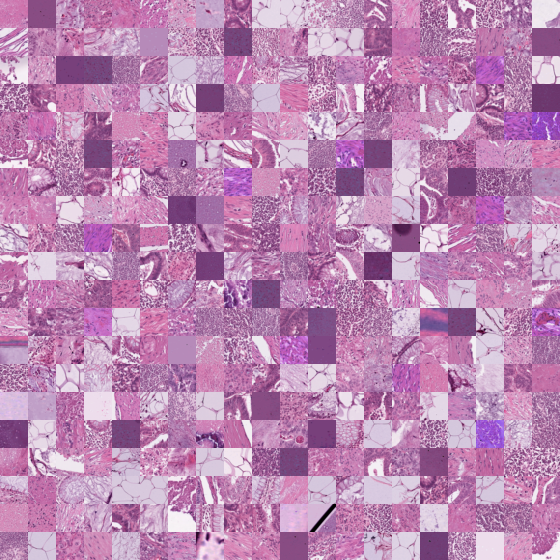

In [ ]:
train_dataset.montage(length=20)

In [ ]:
#### Your code starts here
# define a simple CNN model
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
#### Your code ends here

## 1.4 Optimization  [1 pt]

In [ ]:
#### Your code starts here
#optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#### Your code ends here

## 1.5 Loss  [1 pt]

In [ ]:
#### Your code starts here
# define loss function
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
#### Your code ends here

## 1.6 Training  [1 pt]

In [ ]:
#### Your code starts here
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
#### Your code ends here

100%|██████████| 704/704 [02:27<00:00,  4.79it/s]


## 1.7 Test Evaluation  [1 pt]

Hint: no need to evaluate on the training data to save time

In [ ]:
#### Your code starts here
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('train')
test('test')
#### Your code ends here

==> Evaluating ...
train  auc: 0.986  acc:0.804
test  auc: 0.963  acc:0.771


# <b>2. Transfer Learning [7 pts]</b>

Instead of training from scratch on PATHMNIST dataset, we can start for a pretrained model on the CIFAR-10 dataset and then finetune the last layer only.

Hint: We will create new variables `model_cifar` and `optimizer_ft` and make sure you use the new variables instead of ones from above. `loss` and 'data' remain the same for both runs.

## 2.1 Load pretrained model [1 pt]

https://github.com/chenyaofo/pytorch-cifar-models

In [ ]:
import torch
import torch.nn as nn
model_cifar = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
print(model_cifar)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 35.8MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

## 2.2 Modify the last layer [1 pt]

Make a new layer for the last prediction

In [ ]:
# Define a new fully connected layer for the last prediction
num_classes = 10  # Number of classes in CIFAR-10 dataset
in_features = model_cifar.fc.in_features  # Get the number of input features for the last layer
new_fc_layer = nn.Linear(in_features, num_classes)  # Define a new fully connected layer

# Replace the last fully connected layer of the pre-trained model
model_cifar.fc = new_fc_layer

## 2.3 Optimizer [1 pt]
Freeze all but last layer. We often use small learning rate during finetuning.

In [ ]:
# freeze the weight for all conv layers
# only learn the last linear layer
import torch.optim as optim

for name,param in model_cifar.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

#### Your code starts here
optimizer_ft = optim.SGD(model_cifar.parameters(), lr=lr, momentum=0.9)
#### Your code ends here

## 2.4 Finetune model_cifar [3 pts]

Just finetune it for 1 epoch.

In [ ]:
for epoch in range(1):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model_cifar.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model_cifar(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
#### Your code ends here

100%|██████████| 704/704 [03:24<00:00,  3.44it/s]


## 2.5 Test Evaluation [1 pt]

In [ ]:
# evaluation
def test(split):
  model_cifar.eval()
  y_true = torch.tensor([])
  y_score = torch.tensor([])

  data_loader = train_loader_at_eval if split == 'train' else test_loader

  with torch.no_grad():
      for inputs, labels in data_loader:
          outputs = model_cifar(inputs)

          # Assuming your task is multi-class classification
          targets = labels.squeeze().long()
          outputs = outputs.softmax(dim=-1)
          targets = targets.float().resize_(len(targets), 1)

          y_true = torch.cat((y_true, targets), 0)
          y_score = torch.cat((y_score, outputs), 0)

      y_true = y_true.numpy()
      y_score = y_score.detach().numpy()

      # Calculate accuracy
      accuracy = (y_true.argmax(axis=1) == y_score.argmax(axis=1)).mean()

      print('%s  Accuracy: %.3f' % (split, accuracy))

# Perform evaluation on both train and test sets
print('==> Evaluating (Fine-tuning) ...')

test('train')
test('test')

==> Evaluating (Fine-tuning) ...
train  Accuracy: 0.508
test  Accuracy: 0.543
